# LightGBM

- XGBoost와 부스팅 계열 알고리즘에서 가장 각광을 받고 있음

- XGBoost 보다 학습에 걸리는 시간이 훨씬 적음

### LightGBM의 장점
- XGBoost 대비 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할
    - 원-핫인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행

### LightGBM의 단점
- 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움
- (공식 문서상 대략 10,000건 이하의 데이터 세트)

### 기존 GBM과의 차이점
- 일반적인 균형트리분할(Level Wise) 방식과 달리 **`리프중심 트리분할(Leaf Wise)`** 방식을 사용

- 균형트리분할은 최대한 균형 잡힌 트리를 유지하며 분할하여 트리의 깊이를 최소화하여 오버피팅에 강한구조이지만 균형을 맞추기 위한 시간이 필요함
- 리프중심 트리분할의 경우 최대 손실 값을 가지는 리프노드를 지속적으로 분할하면서 트리가 깊어지고 비대칭적으로 생성
    - 이로써 예측 오류 손실을 최소화하고자 함
    
    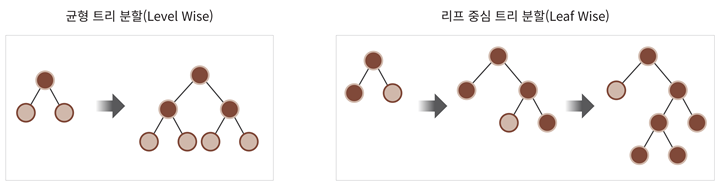

**사이킷런의 Estimator를 상속받아 fit(), predict() 기반의 학습과 예측, 사이킷런의 다양한 유틸리티 활용 가능**

Light GBM 설치
-아나콘다 프롬프트를 관리자 권한으로 실행 한 후 conda 명령으로 수행
conda install -c conda-forge lightgbm

** 윈도우에 설치시 에러가 발생할 수 있음 - 비주얼스튜디오2019 build tools

In [3]:
!pip install lightgbm

In [2]:
import lightgbm

print(lightgbm.__version__)

3.3.3


### LightGBM 하이퍼파라미터

- XGBoost와 매우 유사함
- 유의할 점 :
    - 리프 노드가 계속 분할하면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요

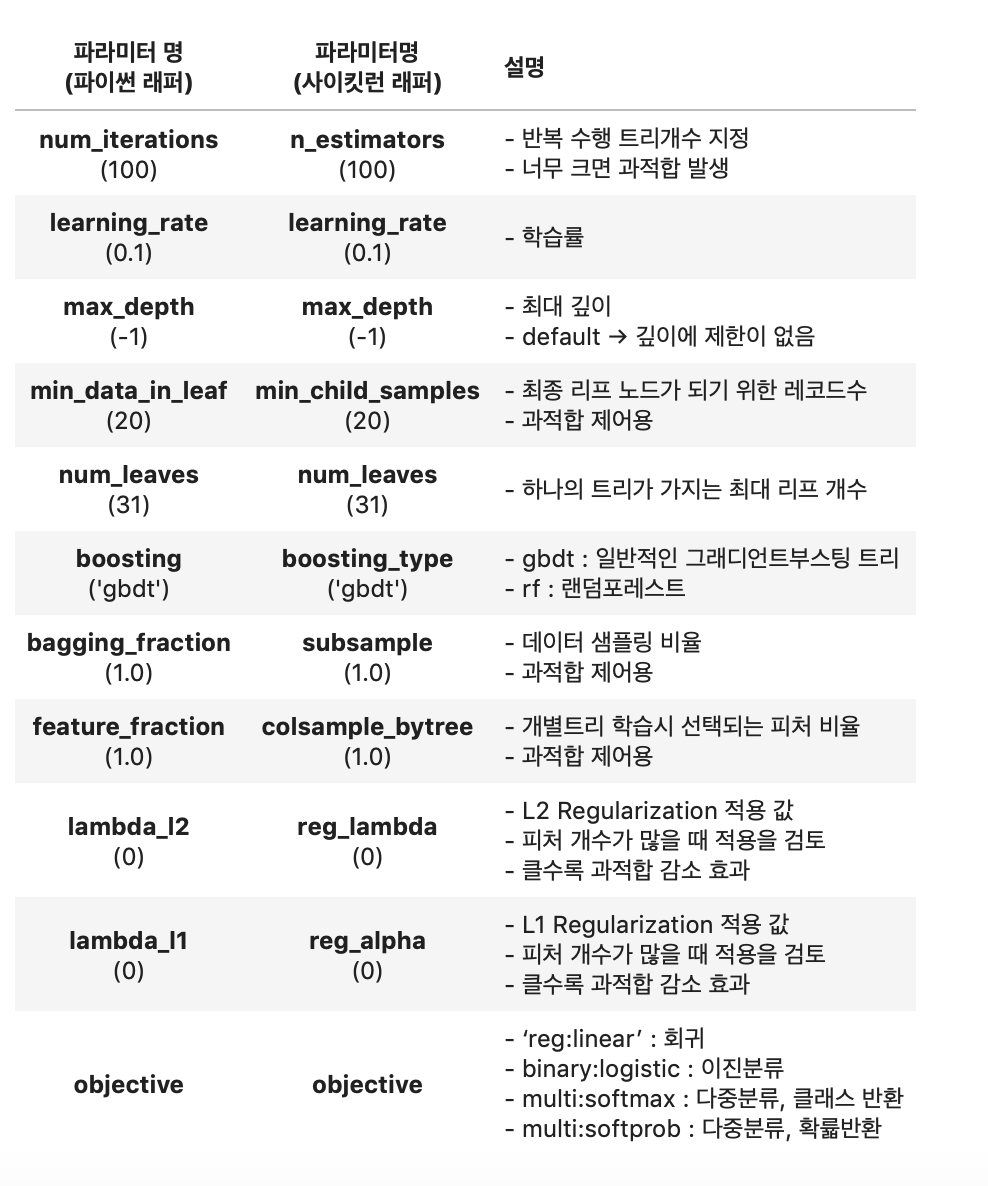

### 하이퍼 파라미터 튜닝 방안

**[방안1] num_leaves 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것**

- num_leaves는 개별 트리가 가질 수 있는 최대 리프 개수로 LightGBM 모델 복잡도를 제어하는 주요 파라미터
    - num_leaves 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델의 복잡도가 커져 과적합 영향도가 커짐
        
        
- min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 변경됨
    - 과적합을 개선하기 위한 중요한 파라미터
    - num_leaves와 학습 데이터의 크기에 따라 달라지지만 보통 큰 값으로 설정하면 트리가 깊어짐을 방지함
        
        
- max_depth는 명시적으로 깊이의 크기를 제한함
    - num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는데 사용
    
    
**[방안2] learning_rate를 작게 하면서 n_estimations를 크게 하는 것**
- n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있으므로 주의



**[방안3] 과적합을 제어하기 위해서 reg_lambda, reg_alpha와 같은 regularization을 적용**


**[방안4] 학습 데이터에 사용할 피처 수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample 파라미터를 적용하는 것도 과적합 제어 방안**

## LightGBM 적용한 위스콘신 유방암 예측

### LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트

In [4]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

**데이터셋 생성 및 분할**

In [6]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

In [7]:
cancer_df = pd.DataFrame(data=ftr, columns=dataset.feature_names)
cancer_df['target']= target # 맨 마지막에 target 열 추가
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [8]:
ftr_df =cancer_df.drop('target',axis=1)
target_df = cancer_df[['target']]

In [9]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr_df, 
                                                  target_df, 
                                                  test_size=0.2, 
                                                  random_state=156 )

In [10]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
172,15.460,11.89,102.50,736.9,0.12570,0.15550,0.20320,0.10970,0.1966,0.07069,...,18.79,17.04,125.00,1102.0,0.1531,0.3583,0.58300,0.18270,0.3216,0.10100
160,11.750,20.18,76.10,419.8,0.10890,0.11410,0.06843,0.03738,0.1993,0.06453,...,13.32,26.21,88.91,543.9,0.1358,0.1892,0.19560,0.07909,0.3168,0.07987
173,11.080,14.71,70.21,372.7,0.10060,0.05743,0.02363,0.02583,0.1566,0.06669,...,11.35,16.82,72.01,396.5,0.1216,0.0824,0.03938,0.04306,0.1902,0.07313
504,9.268,12.87,61.49,248.7,0.16340,0.22390,0.09730,0.05252,0.2378,0.09502,...,10.28,16.38,69.05,300.2,0.1902,0.3441,0.20990,0.10250,0.3038,0.12520
476,14.200,20.53,92.41,618.4,0.08931,0.11080,0.05063,0.03058,0.1506,0.06009,...,16.45,27.26,112.10,828.5,0.1153,0.3429,0.25120,0.13390,0.2534,0.07858


**LightGBM 학습**

In [13]:
from lightgbm import LGBMClassifier
lgbm_wrapper = LGBMClassifier(n_estimators=400) #트리갯수(반복횟수)

evals =[(X_test, y_test)]
# 학습 : 조기 중단 수행 가능(XGBoost와 동일함)
lgbm_wrapper.fit(X_train, y_train,
                 early_stopping_rounds=100,
                 eval_metric='logloss',
                 eval_set=evals,
                 verbose=True)

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

C:\Users\a\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\a\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\a\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\a\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated

LGBMClassifier(n_estimators=400)

- 조기중단으로 145번까지 반복을 수행하고 학습을 종료

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [15]:
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

In [16]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,F1: 0.9682, AUC:0.9905


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

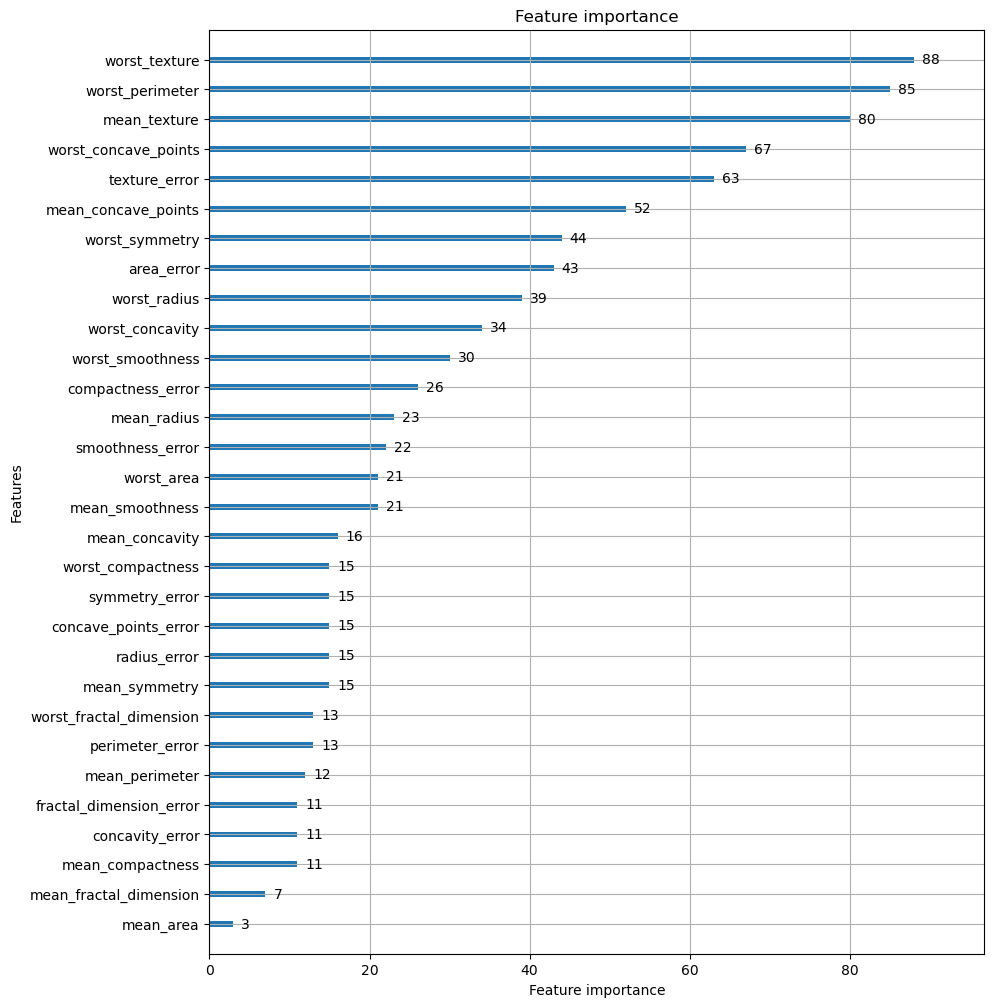

In [17]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax= ax, importance_type='split')